## Import libraries

In [1]:
import pandas as pd
import boto3
from io import StringIO
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

## Load the data from S3

In [2]:
def read_csv_from_s3(bucket_name: str, file_key: str) -> pd.DataFrame:
    """
    Read a CSV file from an S3 bucket into a Pandas DataFrame.

    :param bucket_name: the name of the S3 bucket
    :param file_key: the full path to the csv file
    :return: a dataframe containing the CSV data
    """
    # Create an S3 resource
    s3 = boto3.resource("s3")

    # Get the object from the bucket
    obj = s3.Object(bucket_name, file_key)
    file_content = obj.get()["Body"].read().decode("utf-8")

    # Read the CSV data into a DataFrame
    df = pd.read_csv(StringIO(file_content))
    return df

In [3]:
data = read_csv_from_s3(bucket_name="pet-adoption-mlops", file_key="data/pet_adoption_data.csv")

In [4]:
def cast_object_columns_to_category_type(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cast object columns as category type.

    :param df: initial dataframe
    :return: dataframe with object columns casted to category type
    """
    object_columns = df.select_dtypes(include=["object"]).columns
    df[object_columns] = df[object_columns].astype("category")
    return df

In [5]:
data = cast_object_columns_to_category_type(df=data)

In [6]:
target = "AdoptionLikelihood"
num_features = [
    "AgeMonths",
    "WeightKg",
    "Vaccinated",
    "HealthCondition",
    "TimeInShelterDays",
    "AdoptionFee",
    "PreviousOwner",
]
cat_features = ["PetType", "Breed", "Color", "Size"]

random_state = 42

In [7]:
from typing import Tuple


def split_dataframe_stratified(
    df: pd.DataFrame,
    target_col: str,
    random_state: int,
    frac_train: float = 0.6,
    frac_val: float = 0.2,
    frac_test: float = 0.2,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splits a DataFrame into train, validation, and test sets, stratified on the target column.

    :param df: initial dataframe
    :param target_col: the name fo the target column
    :param frac_train: the fraction of data in the train set, defaults to 0.6
    :param frac_val: the fraction of data in the validation set, defaults to 0.2
    :param frac_test: the fraction of data in the test set, defaults to 0.2
    :param random_state: the random seed, defaults to None
    :return: _description_
    """
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError("Fractions must sum to 1")

    # Perform initial split into train/temp and validate/test
    df_train, df_temp = train_test_split(
        df, stratify=df[target_col], test_size=(1.0 - frac_train), random_state=random_state
    )

    # Further split temp into val/test
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test = train_test_split(
        df_temp, stratify=df_temp[target_col], test_size=relative_frac_test, random_state=random_state
    )

    return df_train, df_val, df_test

In [8]:
df_train, df_val, df_test = split_dataframe_stratified(data, target_col=target, random_state=42)

In [9]:
print(f"Train df shape: {df_train.shape}")
print(f"Validation df shape: {df_val.shape}")
print(f"Test df shape: {df_test.shape}")

Train df shape: (1204, 13)
Validation df shape: (401, 13)
Test df shape: (402, 13)


In [10]:
df_train["AdoptionLikelihood"].value_counts(normalize=True)

AdoptionLikelihood
0    0.671927
1    0.328073
Name: proportion, dtype: float64

In [11]:
df_val["AdoptionLikelihood"].value_counts(normalize=True)

AdoptionLikelihood
0    0.670823
1    0.329177
Name: proportion, dtype: float64

In [12]:
df_test["AdoptionLikelihood"].value_counts(normalize=True)

AdoptionLikelihood
0    0.671642
1    0.328358
Name: proportion, dtype: float64

In [13]:
# Define the CatBoost classifier
model = CatBoostClassifier(
    iterations=100, learning_rate=0.1, depth=6, cat_features=cat_features, random_state=random_state
)

# Train the model
model.fit(
    df_train[num_features + cat_features],
    df_train[target],
    eval_set=(df_val[num_features + cat_features], df_val[target]),
    verbose=True,
)

# Make predictions on the test set
y_pred = model.predict(df_test[num_features + cat_features])

# Evaluate the model
accuracy = (y_pred == df_test["AdoptionLikelihood"]).mean()
print(f"Accuracy: {accuracy}")

0:	learn: 0.6423758	test: 0.6433426	best: 0.6433426 (0)	total: 49ms	remaining: 4.85s
1:	learn: 0.5994060	test: 0.6003663	best: 0.6003663 (1)	total: 50ms	remaining: 2.45s
2:	learn: 0.5623964	test: 0.5637664	best: 0.5637664 (2)	total: 50.8ms	remaining: 1.64s
3:	learn: 0.5310919	test: 0.5335831	best: 0.5335831 (3)	total: 51.6ms	remaining: 1.24s
4:	learn: 0.5027181	test: 0.5051196	best: 0.5051196 (4)	total: 52.3ms	remaining: 994ms
5:	learn: 0.4784457	test: 0.4808145	best: 0.4808145 (5)	total: 53ms	remaining: 830ms
6:	learn: 0.4585821	test: 0.4613417	best: 0.4613417 (6)	total: 53.7ms	remaining: 714ms
7:	learn: 0.4411113	test: 0.4437549	best: 0.4437549 (7)	total: 55.5ms	remaining: 639ms
8:	learn: 0.4255118	test: 0.4284788	best: 0.4284788 (8)	total: 57ms	remaining: 577ms
9:	learn: 0.3999067	test: 0.4047256	best: 0.4047256 (9)	total: 57.9ms	remaining: 521ms
10:	learn: 0.3788305	test: 0.3865273	best: 0.3865273 (10)	total: 58.7ms	remaining: 475ms
11:	learn: 0.3624981	test: 0.3719622	best: 0.3719

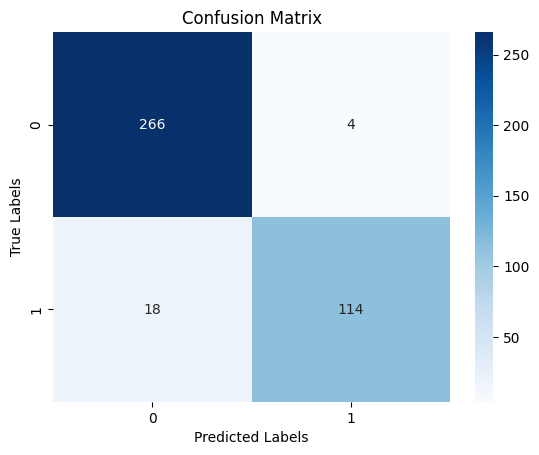

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = df_test["AdoptionLikelihood"]
y_pred = y_pred

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
# Add true and predicted labels to the confusion matrix plot
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Calculate classification metrics for each class and total
report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])

# Print the classification report
print(report)

              precision    recall  f1-score   support

     Class 0       0.94      0.99      0.96       270
     Class 1       0.97      0.86      0.91       132

    accuracy                           0.95       402
   macro avg       0.95      0.92      0.94       402
weighted avg       0.95      0.95      0.94       402

